In [ ]:
pip install py-mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 63.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd


In [ ]:

df = pd.read_csv('allianz_data.csv')

In [ ]:
# Let's add the length of customer names as a numerical data point.
df['name_len'] = df['customers'].apply(len)

# Let's find the number of words in the name.
df['word_count'] = df['customers'].apply(lambda x: len(x.split()))

# View the final version of the data
print(df[['customers', 'name_len', 'word_count']].head())


       customers  name_len  word_count
0     Ahmad Zaki        10           2
1     Ali Yılmaz        10           2
2       Chen Wei         8           2
3  David Beckham        13           2
4    Emily Blunt        11           2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# ready data (X: Enter, y: target)
# isim uzunluklarını (name_len) alıp PyTorch'un anlayacağı Tensor yapısına çeviririz
X = torch.tensor(df['name_len'].values, dtype=torch.float32).view(-1, 1)

# hedef (y): İsim uzunluğu 12'den büyükse 1, değilse 0 Basit Sınıflandırma
y = torch.tensor((df['name_len'] > 12).values, dtype=torch.float32).view(-1, 1)



In [ ]:
class AllianzModel(nn.Module):
    def __init__(self):
        super(AllianzModel, self).__init__()
        self.layer1 = nn.Linear(1, 10)
        self.layer2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

model = AllianzModel()

In [ ]:
#cihazı belirle eğer NVIDIA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# modeli oluştur ve GPU'ya gönder
model = AllianzModel().to(device)

# verileri X ve y GPU'ya gönder
X = X.to(device)
y = y.to(device)

print(f"Model şu an {device} üzerinde çalışmaya hazır!")

Model şu an cuda üzerinde çalışmaya hazır!


In [ ]:
# kayıp fonksiyonu
criterion = nn.BCELoss()

# Optimizer (Hataları düzeltmek için ağırlıkları günceller)
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [ ]:
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Kayıp (Loss): {loss.item():.4f}')

Epoch [10/100], Kayıp (Loss): 0.8845
Epoch [20/100], Kayıp (Loss): 0.7085
Epoch [30/100], Kayıp (Loss): 0.7077
Epoch [40/100], Kayıp (Loss): 0.6803
Epoch [50/100], Kayıp (Loss): 0.6783
Epoch [60/100], Kayıp (Loss): 0.6694
Epoch [70/100], Kayıp (Loss): 0.6643
Epoch [80/100], Kayıp (Loss): 0.6579
Epoch [90/100], Kayıp (Loss): 0.6514
Epoch [100/100], Kayıp (Loss): 0.6443


In [ ]:
# test için yeni bir isim uzunluğu verelim
test_name_len = torch.tensor([[16.0]]).to(device)

# modeli tahmin moduna al
model.eval()
with torch.no_grad():
    prediction = model(test_name_len)

print(f"Tahmin skoru: {prediction.item():.4f}")

if prediction.item() > 0.5:
    print("Sonuç: Bu isim 12 karakterden UZUN (Sınıf 1)")
else:
    print("Sonuç: Bu isim 12 karakterden KISA (Sınıf 0)")


Tahmin skoru: 0.5166
Sonuç: Bu isim 12 karakterden UZUN (Sınıf 1)


In [ ]:
import matplotlib.pyplot as plt

loss_list = [] # kayıpların birikmesi için burası gerekli

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()

    # loss değerini CPU'ya çekip listeye ekle
    loss_list.append(loss.item())
print("Eğitim tamamlandı ve kayıplar kaydedildi")

Eğitim tamamlandı ve kayıplar kaydedildi


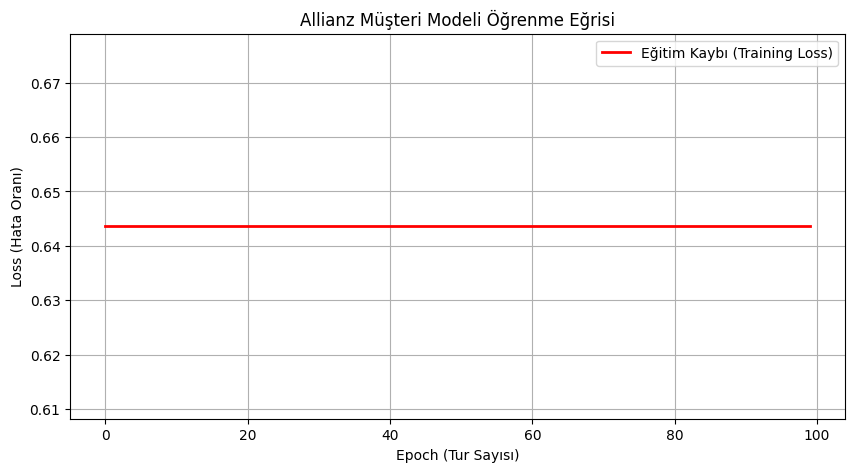

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Eğitim Kaybı (Training Loss)', color='red', linewidth=2)
plt.title('Allianz Müşteri Modeli Öğrenme Eğrisi')
plt.xlabel('Epoch (Tur Sayısı)')
plt.ylabel('Loss (Hata Oranı)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()

def tahmin_et(isim):
  uzunluk = len(isim)
  test_tensor = torch.tensor([[float(uzunluk)]]).to(device)

  with torch.no_grad():
    cikti = model(test_tensor)
    olasilik = cikti.item()

  sonuc = "12 karakterden UZUN" if olasilik > 0.5 else "12 karakterden KISA"
  print(f"İsim: {isim} | Uzunluk: {uzunluk} | Tahmin: {sonuc} (Skor: {olasilik:.4f})")

tahmin_et("Hüseyin Susever")
tahmin_et("Ali")

İsim: Hüseyin Susever | Uzunluk: 15 | Tahmin: 12 karakterden UZUN (Skor: 0.5057)
İsim: Ali | Uzunluk: 3 | Tahmin: 12 karakterden KISA (Skor: 0.3747)
